#INIT

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip3 install import_ipynb
!sudo add-apt-repository ppa:rabbitmq/rabbitmq-erlang -y
!sudo apt update
!sudo apt install erlang
!erl -noshell -s c c drive/MyDrive/harp/tok -s init stop # Make sure to adjust file paths
!erl -noshell -s c c drive/MyDrive/harp/pprint -s init stop # Make sure to adjust file paths

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:00
Repository: 'deb https://ppa.launchpadcontent.net/rabbitmq/rabbitmq-erlang/ubuntu/ jammy main'
Description:
A fork of the official Erlang packages for Debian, produced to package most recent releases as they come out.
More info: https://launchpad.net/~rabbitmq/+archive/ubuntu/rabbitmq-erlang
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/rabbitmq-ubuntu-rabbitmq-erlang-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/rabbitmq-ubuntu-rabbitmq-erlang-jammy.list
Adding key to /etc/apt/trusted.gpg.d/rabbitmq-ubuntu-rabbitmq-erlang.gpg with fingerprint B279943D2A549531E144B875F77F1EDA57EBB1CC
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com

In [ ]:
import import_ipynb
import drive.MyDrive.harp.Common_functions as Common_functions # Make sure to adjust file paths

importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Common_functions.ipynb
Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
import os
from keras.models import Model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from typing import Tuple, List, Any
from itertools import takewhile
from collections import deque
import subprocess

#Seq2seq

In [ ]:
import drive.MyDrive.harp.Idiomatizer_func as Idiomatizer_func # Make sure to adjust file paths

importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Idiomatizer_func.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
word2index_seq2seq = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'word2index_seq2seq.csv'), eval_value=True, eval_key=False)
index2word_seq2seq = Common_functions.reverse_dict(word2index_seq2seq)

parameters_seq2seq = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'parameters_seq2seq.csv'))
MAX_LENGTH_NONIDIOMATIC = parameters_seq2seq['MAX_LENGTH_NONIDIOMATIC']
MAX_LENGTH_IDIOMATIC    = parameters_seq2seq['MAX_LENGTH_IDIOMATIC']
latent_dim              = 128
embedding_dim           = 64

num_tokens = len(word2index_seq2seq)

In [ ]:
(encoder_inputs,
 decoder_inputs,
 encoder_outputs,
 decoder_outputs,
 encoder_states,
 emb_layer,
 decoder_lstm,
 decoder_encoder_attention_layer,
 decoder_dense) = Idiomatizer_func.generate_encoder_decoder_inputs_outputs(num_tokens, latent_dim, embedding_dim, MAX_LENGTH_NONIDIOMATIC, MAX_LENGTH_IDIOMATIC, encoder_rnn_num = 2, stacked_encoder = True, use_gru=False)

model_seq2seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_seq2seq.load_weights(os.path.join(Common_functions.saved_model_path,'seq2seq_model.h5'))

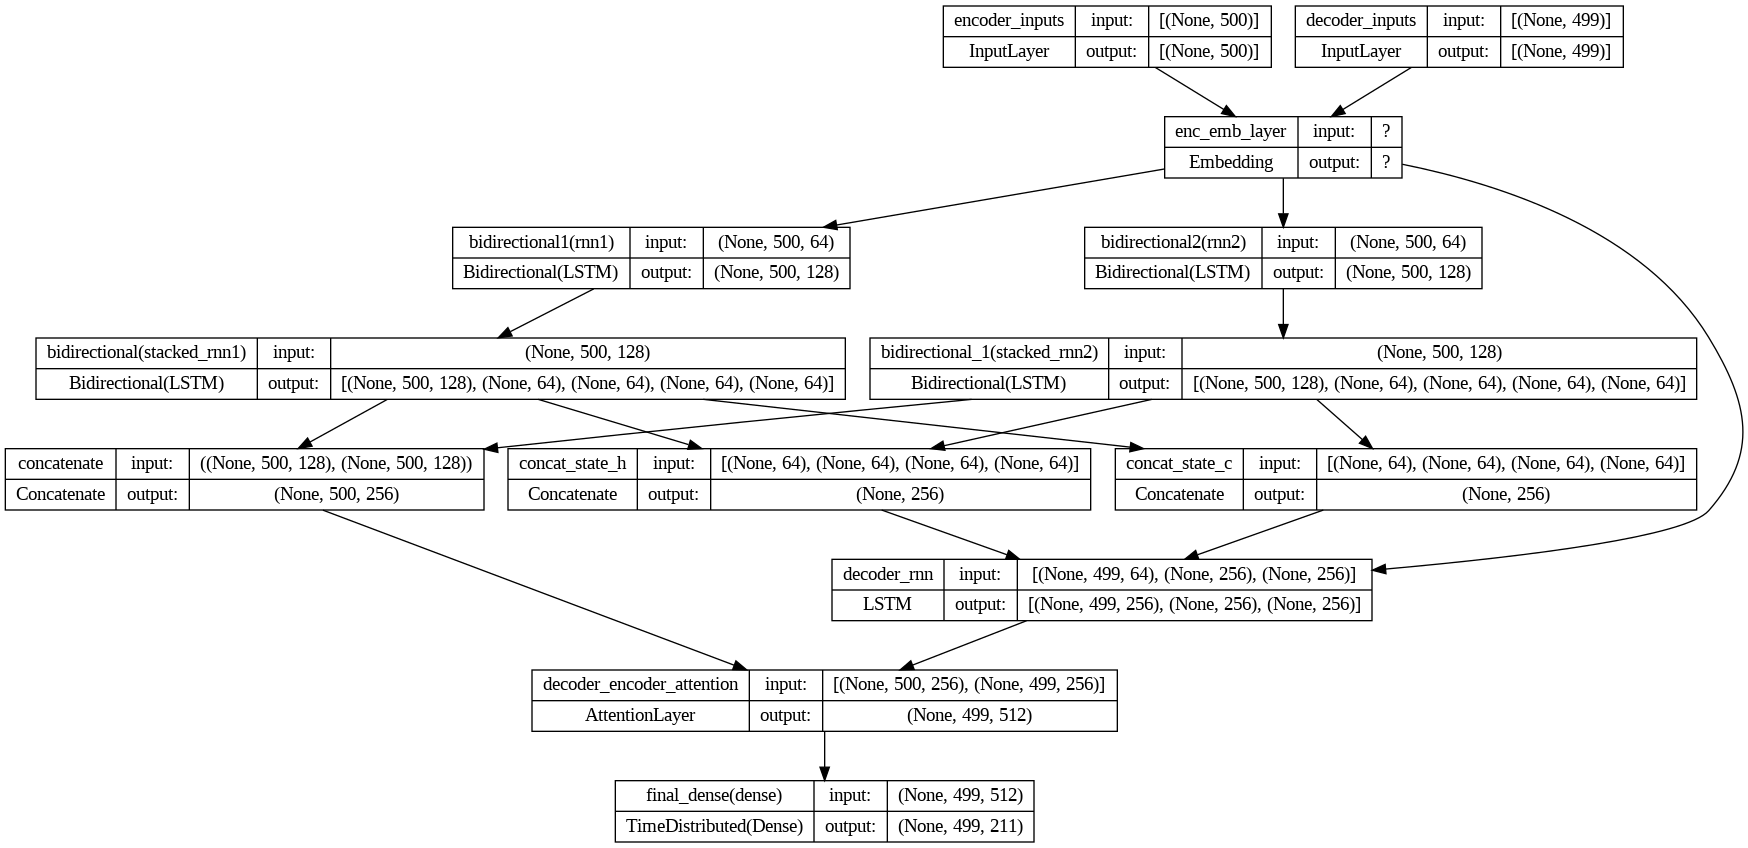

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_seq2seq,show_shapes=True)

In [ ]:
(encoder_model, decoder_model) = \
    Idiomatizer_func.generate_encoder_decoder_model(encoder_inputs,
                                                    encoder_states,
                                                    encoder_outputs,
                                                    latent_dim,
                                                    embedding_dim,
                                                    emb_layer,
                                                    decoder_inputs,
                                                    decoder_lstm,
                                                    decoder_encoder_attention_layer,
                                                    decoder_dense,
                                                    MAX_LENGTH_NONIDIOMATIC,
                                                    use_gru = False)

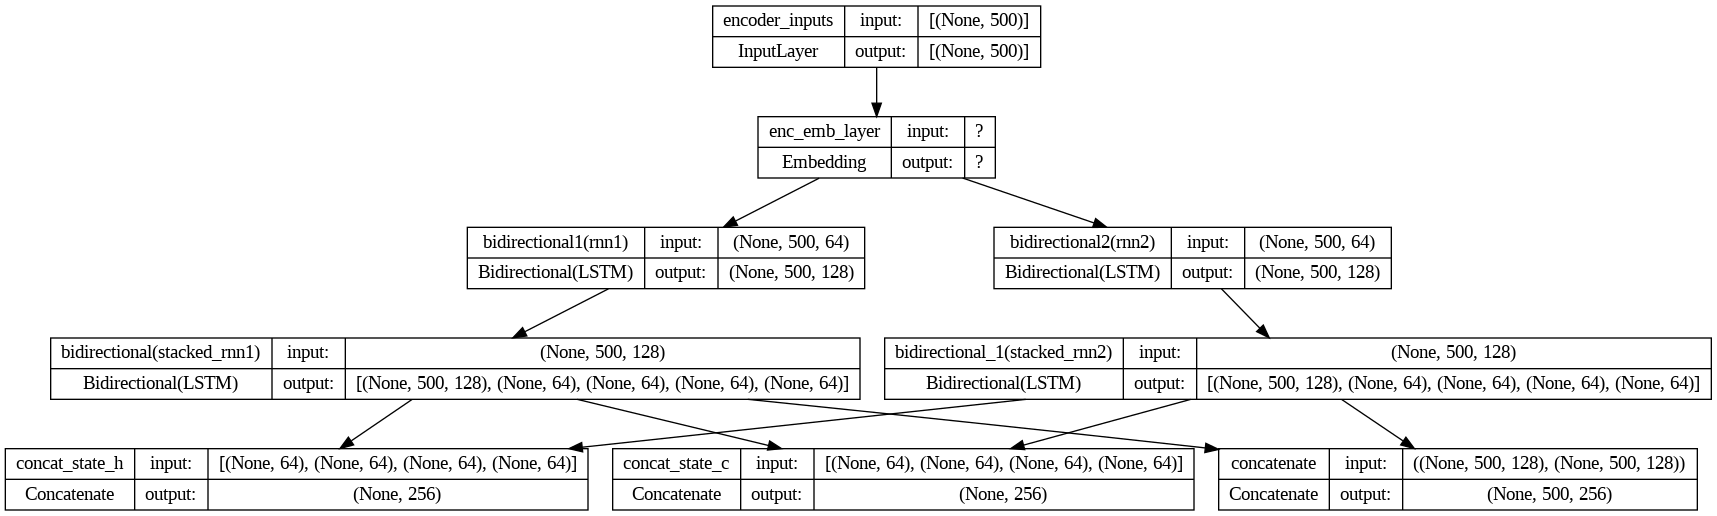

In [ ]:
plot_model(encoder_model,show_shapes=True)

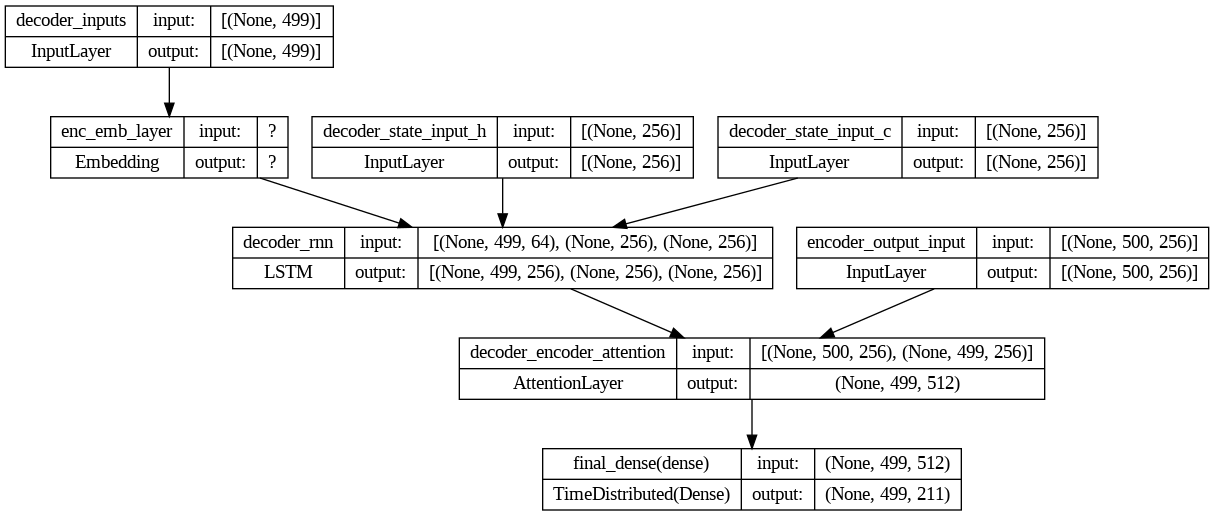

In [ ]:
plot_model(decoder_model,show_shapes=True)

#SEQ2SEQ TEST

In [ ]:
def tokenize_chunk(file_names, include_line_num = False):
    file_names = [ "'{0}'".format(fn) for fn in file_names ]
    #print(file_names)
    command = "erl -noshell -s tok tokenize_files {0} -s init stop".format(' '.join(file_names))

    res_subprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    result = res_subprocess.stdout.read()
    erl_scan_outputs = result.decode('utf-8')

    token_seqs = []
    for erl_scan_output in erl_scan_outputs.split('~~~'):

        erl_scan_output = erl_scan_output.replace('\n ',';')[1:-2]
        erl_scan_output = erl_scan_output.replace("','",'comma')
        erl_scan_output = erl_scan_output.split('},;')
        erl_scan_output = list(map(lambda x:x[1:],erl_scan_output))
        token_seq = []
        for token_info in erl_scan_output:
            cat_or_tok, line_num = token_info.split(',')[0:2]
            optional_third = token_info[len(cat_or_tok)+1+len(line_num)+1:]
            if cat_or_tok.startswith("'"): cat_or_tok=cat_or_tok[1:]
            if cat_or_tok.endswith  ("'"): cat_or_tok=cat_or_tok[:-1]

            if cat_or_tok != 'atom':
                if optional_third.startswith("'"): optional_third=optional_third[1:]
                if optional_third.endswith  ("'"): optional_third=optional_third[:-1]

            to_append = []
            if optional_third:
                to_append = [optional_third, cat_or_tok]
                #token_seq.append((optional_third, cat_or_tok))
            else:
                to_append = [cat_or_tok, None]
                #token_seq.append((cat_or_tok, None))
            if include_line_num:
                to_append.append(int(line_num)-1)
            token_seq.append(tuple(to_append))
        token_seqs.append(token_seq)
    return token_seqs

def tokenize_files(file_names, include_line_num = False, chunk_size=100, return_list : bool = False):
    token_seqs = deque() if not return_list else []
    for i in range(0,len(file_names),chunk_size):
        file_names_chunk = file_names[i:i+chunk_size]
        tokenized_chunk  = tokenize_chunk(file_names_chunk, include_line_num)
        token_seqs.extend(tokenized_chunk)
    return token_seqs

def tokenize_codes_chunk(code, file_id=None):
    assert isinstance(code,list)
    if file_id is None:
        file_id = ''
    file_names = []
    for i, c in enumerate(code):
        file_name = os.path.join(Common_functions.data_path,'tmp_files/tmp{0}{1}.txt'.format(file_id,i))
        with open(file_name, 'w') as f:
            f.write(c)
        file_names.append(file_name)
    token_seq = tokenize_files(file_names)
    return token_seq

def tokenize_code(code, include_line_num=False, file_id=None):
    if isinstance(code,list) or isinstance(code,deque):
        token_seqs = deque()
        for i in range(0,len(code),100):
            code_chunk = code[i:i+100]
            tokenized_chunk  = tokenize_codes_chunk(code_chunk, file_id)
            token_seqs.extend(tokenized_chunk)
        return token_seqs
    elif isinstance(code,str):
        file_name = os.path.join(Common_functions.data_path,'tmp_files/tmp.txt')
        with open(file_name, 'w') as f:
            f.write(code)
        token_seq = tokenize_files([file_name], include_line_num)[0]
        return token_seq
    else:
        raise Exception('Can only tokenize a string or list of strings')

In [ ]:
import os
import subprocess

def erl_pretty_printer(source_codes):
    print(source_codes)
    if not source_codes:
        return []

    file_names = []
    to_keep = []
    for i, source_code in enumerate(source_codes):
        if '~' in source_code:
            to_keep.append(i)
        source_code = source_code.replace('~','')
        file_content = (
'''-module(file).
-export([qwertzuiopasdfghjklyxcvbnm/0]).

qwertzuiopasdfghjklyxcvbnm() -> ''')
        file_content += source_code.split('->')[0] + '.\n'
        file_content += source_code
        file_name = os.path.join(Common_functions.tmp_path, f'ppfile{i}.erl')
        file_names.append(file_name)
        with open(file_name,'w') as f:
            f.write(file_content)

    assert len(file_names) == len(source_codes)
    file_names = [ '"{0}"'.format(fn) for fn in file_names ]
    assert len(file_names) == len(source_codes)
    outputs = []

    test_set_len = len(file_names)
    batch_size = 100
    fits_into_batches = test_set_len % batch_size == 0
    for i in range(test_set_len//batch_size + (0 if fits_into_batches else 1)):
        command = "erl -noshell -s pprint pretty_print {0} -s init stop".format(' '.join(file_names[i*batch_size:(i+1)*batch_size]))
        #command = "erl -noshell -s pprint pretty_print -s init stop"
        res_subprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        result = res_subprocess.stdout.read()
        erl_outputs = result.decode('utf-8')
        erl_outputs = erl_outputs.split('~~~')
        erl_outputs = ['\n'.join(erl_output.splitlines()[6:]) for erl_output in erl_outputs]
        outputs += erl_outputs

    for i in to_keep:
        outputs[i] = source_codes[i]

    return outputs

In [ ]:
def idiomatize(codes,
               encoder_model, decoder_model,
               word2index_seq2seq, index2word_seq2seq,
               MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC,
               throw_when_unk_failure=False,
               batch_size : int = 2**7,
               to_string : bool = True, pprint : bool = False):
    if not codes:
        return []
    if isinstance(codes[0],str):
        input_seqs = tokenize_code(codes)
        input_seqs = [ Common_functions.process_tokenized_code(input_seq) for input_seq in input_seqs ]
    elif isinstance(codes[0],list) or isinstance(codes[0],tuple):
        input_seqs = codes
    else:
        assert False
    input_seqs, unk_dicts = zip(*input_seqs)
    input_seqs = [
        [word2index_seq2seq[token] for token in input_seq if token in word2index_seq2seq.keys()]
        for input_seq in input_seqs
    ]
    input_seqs = pad_sequences(input_seqs, maxlen=MAX_LENGTH_NONIDIOMATIC, padding='post', value=0., dtype='float32')

    decoded_sequences = deque()
    test_set_len = len(input_seqs)
    fits_into_batches = test_set_len % batch_size == 0
    for i in range(test_set_len//batch_size + (0 if fits_into_batches else 1)):
        fr, to = batch_size*i, batch_size*(i+1)
        bs = len(input_seqs[fr:to])
        assert bs <= batch_size
        decoded_sequences.extend(
            Idiomatizer_func.decode_sequences(input_seqs[fr:to],
                            encoder_model, decoder_model,
                            word2index_seq2seq, index2word_seq2seq,
                            MAX_LENGTH_IDIOMATIC, bs)
        )

    assert test_set_len == len(decoded_sequences)
    if not to_string:
        return decoded_sequences

    #decoded_sequences = np.array(decoded_sequences)


    idiomatic_codes = [
        Idiomatizer_func.tokens_to_code(decoded_sequence, unk_dict, throw_when_unk_failure=throw_when_unk_failure)
        for decoded_sequence, unk_dict in zip(decoded_sequences, unk_dicts)
    ]
    assert len(idiomatic_codes) == test_set_len

    if pprint:
        pretty_idiomatic_codes = erl_pretty_printer(idiomatic_codes)
        idiomatic_codes = [
            pretty_code
            if (code and
                       code.replace(' ','').replace('\t','').replace('\n','') ==
                pretty_code.replace(' ','').replace('\t','').replace('\n',''))
            else code
            for code, pretty_code in zip(idiomatic_codes, pretty_idiomatic_codes, strict=True)
        ]

        assert len(pretty_idiomatic_codes) == test_set_len

    return idiomatic_codes

In [ ]:
test1 = '''f(X) when length(X) == 0 -> [(3),(4),(((5))),6*(8)].'''
test2 = '''punishment(NEWq) when length(NEWq) == 0 -> hd(tl([])).'''

test0 = '''f(L) when length(L) == 0 -> case X of 5.'''
test0 = '''f(L) when length(L) == 0 -> case X of 0 -> true; 1 -> '''
test1 = '''f(L) when length(L) == 0 -> case case .'''
test2 = '''f(X) when length(X) == 0 -> empty;
f(X) -> hd(X).'''
test3 = '''f(X) when length(X) == 0 -> error;
f(X) -> lists:max(X).'''
test4 = '''f(Xs) when length(Xs) > 0 -> hd(Xs) + f(lists:nthtail(1, Xs)).'''
test0 = '''f(L) when length(L) == 0 ->
case X of 0 -> true; 1 ->'''

ic = idiomatize([test0],
                                 encoder_model, decoder_model,
                                 word2index_seq2seq, index2word_seq2seq,
                                 MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC, to_string = True,
                                 pprint=False)
for x in ic:
    print(x)

1/1 [==============================] - 0s 49ms/step



In [ ]:
def compare_code_strings(code1, code2):
    return (
        code1.replace(' ','').replace('\t','').replace('\n','')
                                 ==
        code2.replace(' ','').replace('\t','').replace('\n','')
    )

In [ ]:
process_test_data = False
if process_test_data:
    with open(os.path.join(Common_functions.parameter_path,"test_codes_10test.dump"),'rb') as nc:
        test_codes=pickle.load(nc)

    nonidiomatic_codes, goal_idiomatic_codes = zip(*test_codes)
    del test_codes
    nonidiomatic_codes, goal_idiomatic_codes = list(nonidiomatic_codes), list(goal_idiomatic_codes)

    nonidiomatic_codes = Common_functions.tokenize_code(nonidiomatic_codes)
    nonidiomatic_codes_w_unk_dict = [ Common_functions.process_tokenized_code(nonidiomatic_code, insert_beos=True) for nonidiomatic_code in nonidiomatic_codes ]
    nonidiomatic_codes, unk_dicts = zip(*nonidiomatic_codes_w_unk_dict)

    goal_idiomatic_codes_len = [ len(x) for x in Common_functions.tokenize_code(goal_idiomatic_codes) ]
    ################################################################################
    assert len(nonidiomatic_codes) == len(goal_idiomatic_codes) == len(nonidiomatic_codes_w_unk_dict)
    nonidiomatic_codes            = list(nonidiomatic_codes)
    nonidiomatic_codes_w_unk_dict = list(nonidiomatic_codes_w_unk_dict)
    boundary = 500
    print('before', len(nonidiomatic_codes_w_unk_dict))
    i = 0
    while i < len(nonidiomatic_codes):
        if len(nonidiomatic_codes[i]) > boundary or goal_idiomatic_codes_len[i] > boundary:
            assert nonidiomatic_codes[i] == nonidiomatic_codes_w_unk_dict[i][0]
            del nonidiomatic_codes[i]
            del nonidiomatic_codes_w_unk_dict[i]
            del goal_idiomatic_codes[i]
            del goal_idiomatic_codes_len[i]
            #del test_codes[i]
        else:
            i -=- 1
    assert all(len(code) <= boundary for code     in nonidiomatic_codes)
    assert all(code_len  <= boundary for code_len in goal_idiomatic_codes_len)
    assert len(nonidiomatic_codes) == len(goal_idiomatic_codes) == len(nonidiomatic_codes_w_unk_dict)

    print('after', len(nonidiomatic_codes_w_unk_dict))
    with open(os.path.join(Common_functions.parameter_path,'test_nonidiomatic_codes_w_unk_dict.dump'),'wb') as p:
        pickle.dump(nonidiomatic_codes_w_unk_dict,p)
    with open(os.path.join(Common_functions.parameter_path,'test_goal_idiomatic_codes.dump'),'wb') as p:
        pickle.dump(goal_idiomatic_codes,p)
    with open(os.path.join(Common_functions.parameter_path,'test_nonidiomatic_codes.dump'),'wb') as p:
        pickle.dump(nonidiomatic_codes,p)
else:
    with open(os.path.join(Common_functions.parameter_path,"test_nonidiomatic_codes_w_unk_dict.dump"),'rb') as p:
        nonidiomatic_codes_w_unk_dict=pickle.load(p)
    with open(os.path.join(Common_functions.parameter_path,"test_goal_idiomatic_codes.dump"),'rb') as p:
        goal_idiomatic_codes=pickle.load(p)
    with open(os.path.join(Common_functions.parameter_path,"test_nonidiomatic_codes.dump"),'rb') as p:
        nonidiomatic_codes=pickle.load(p)

In [ ]:
print(len(nonidiomatic_codes_w_unk_dict))
print(nonidiomatic_codes_w_unk_dict[0])

4464
(['BOS', 'atom0', '(', 'var0', 'comma', 'var1', 'comma', 'var2', 'comma', 'var3', 'comma', 'var4', ')', '->', 'var5', '=', 'element', '(', 'erlang', ':', 'abs', '(', 'integer0', ')', 'comma', '{', 'element', '(', '-', 'integer1', 'comma', 'var3', ')', 'comma', 'lists', ':', 'map', '(', 'fun', 'length', '/', '1', 'comma', 'hd', '(', 'tl', '(', '[', ']', '--', '[', ']', ')', ')', ')', 'comma', 'tuple_to_list', '(', '{', '}', ')', '}', ')', 'comma', 'var6', '=', 'element', '(', 'tuple_size', '(', 'atom1', '(', '-', 'integer2', 'comma', 'atom2', 'comma', 'integer3', 'comma', 'true', 'comma', 'true', ')', ')', 'comma', 'atom1', '(', 'integer4', 'comma', 'atom2', 'comma', 'integer3', 'comma', 'true', 'comma', 'false', ')', ')', 'comma', 'var7', '=', '{', 'atom3', '(', 'atom4', 'comma', '0', 'comma', 'atom5', ')', 'comma', 'list_to_tuple', '(', 'var2', ')', 'comma', 'element', '(', '-', 'integer5', '+', '-', 'integer3', 'comma', 'atom1', '(', '-', 'integer3', 'comma', 'atom2', 'comma', '

In [ ]:
# Using only one third of testing data here for time considerations
nonidiomatic_codes_w_unk_dict = nonidiomatic_codes_w_unk_dict[::3]

In [ ]:
predicted_idiomatic_codes = Idiomatizer_func.idiomatize(nonidiomatic_codes_w_unk_dict,
                                                        encoder_model, decoder_model,
                                                        word2index_seq2seq, index2word_seq2seq,
                                                        MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC,
                                                        to_string=True, batch_size = 2**5)

A streamkimeneten csak az utolsó 5000 sor látható.
1/1 [==============================] - 0s 53ms/step


In [ ]:
all_num, correct = 0, 0
for i, (predicted, goal, nonidiomatic) in enumerate(zip(predicted_idiomatic_codes, goal_idiomatic_codes[::3], nonidiomatic_codes[::3])):
    if compare_code_strings(predicted, goal):
        correct -=- 1
    else:
        pass
    all_num -=- 1

print(correct, all_num, correct/all_num)

1480 1488 0.9946236559139785


#Finder

In [ ]:
import drive.MyDrive.tidierpp.Finder_func as Finder_func

importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Finder_func.ipynb


In [ ]:
word2index_finder = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'word2index_finder.csv'), eval_value=True, eval_key=False)
index2word_finder = Common_functions.reverse_dict(word2index_finder)

parameters_finder = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'parameters_finder.csv'), eval_value=True, eval_key=False)
MAX_LENGTH_CODE   = parameters_finder['MAX_LENGTH_CODE']
MAX_LENGTH_CHUNK  = parameters_finder['MAX_LENGTH_CHUNK']

In [ ]:
model_finder = load_model(os.path.join(Common_functions.saved_model_path,'finder_model.h5'), compile=False, custom_objects={
    'AttentionLayer'               : Common_functions.AttentionLayer,
    'Activation'                   : Common_functions.Activation})

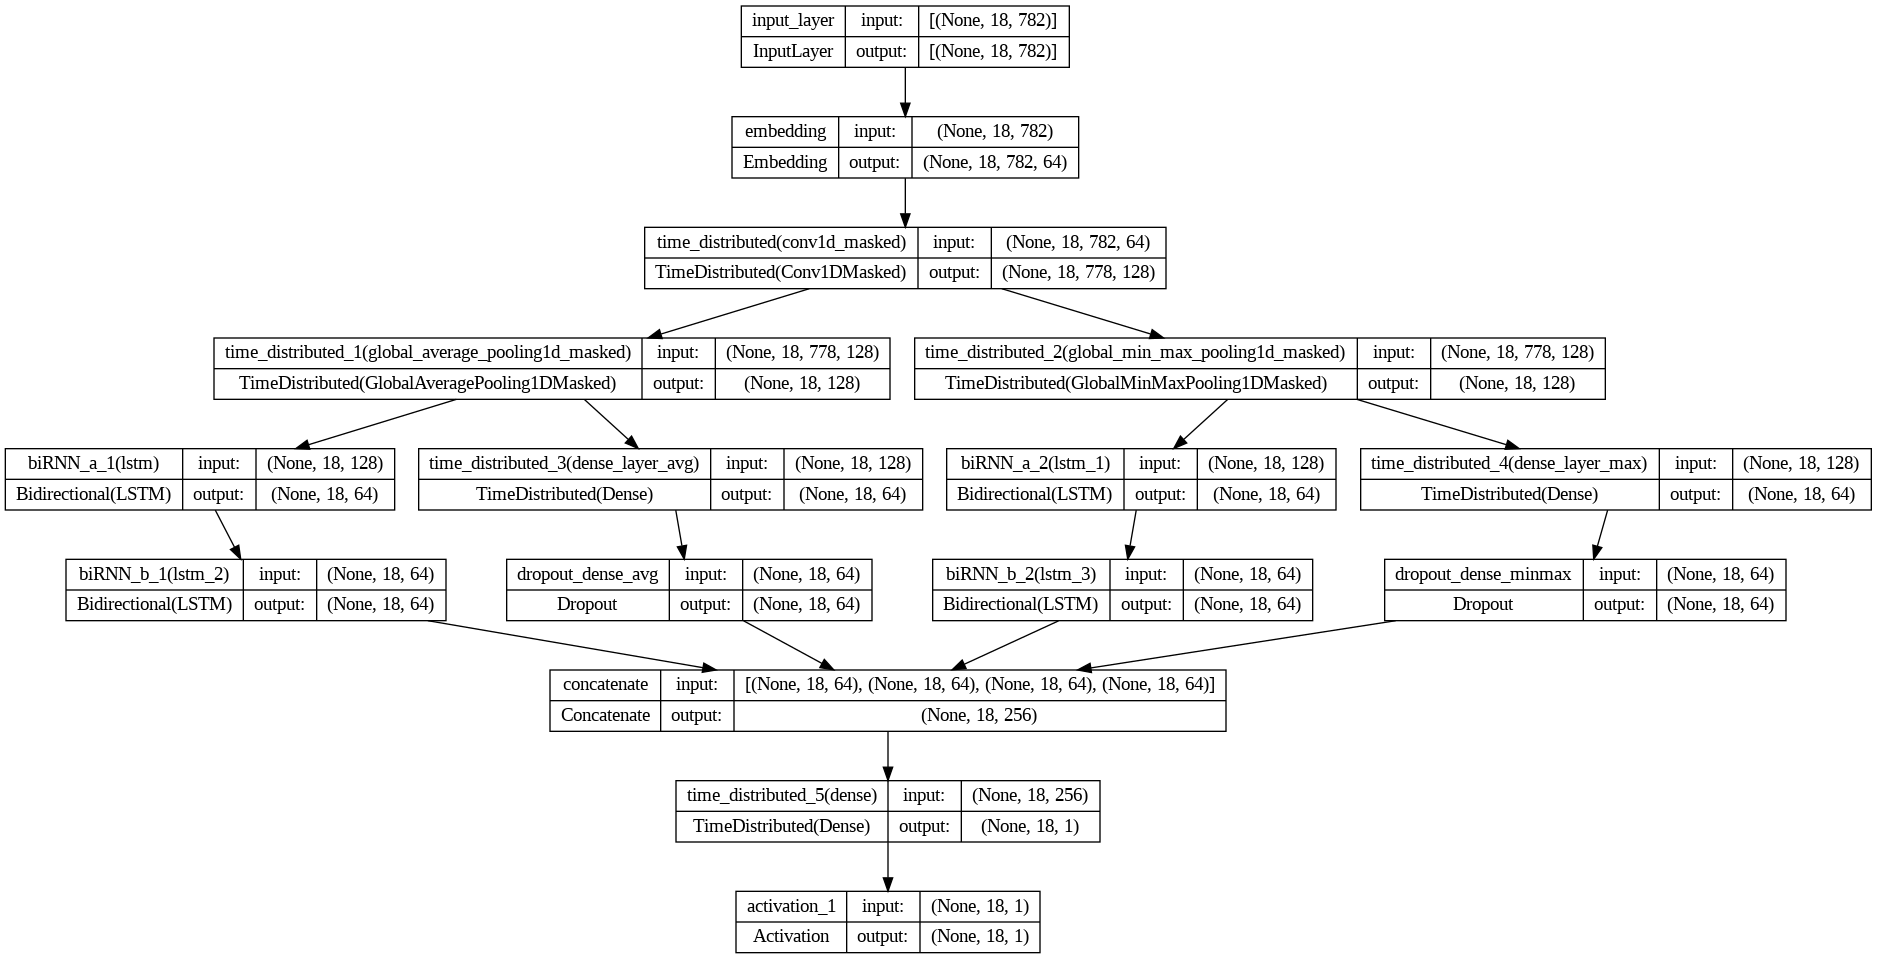

In [ ]:
plot_model(model_finder, show_shapes=True)

In [ ]:
def preds_to_indexes(sequences):
    index_sequences = []
    for categorical_sequence in sequences:
        index_sequence = []
        for categorical in categorical_sequence:
            index_sequence.append(np.argmax(categorical))
        index_sequences.append(index_sequence)
    return index_sequences

def preds_to_binary(sequences):
    binary_sequences = []
    for prob_sequence in sequences:
        binary_sequence = np.round(prob_sequence).astype(int)
        binary_sequences.append(list(binary_sequence))
    return binary_sequences

def split_interval(fr : int, to : int, split_len : int) -> List[Tuple[int,int]]:
    splitted_intervals = []
    for i in range(fr,to,split_len):
        splitted_intervals.append((i,min(i+split_len,to)))
    return splitted_intervals

def split_list_evenly(li : List[Any], split_len : int) -> List[List[Any]]:
    splitted_intervals = split_interval(0,len(li),split_len)
    splitted_list = [li[f:t] for f, t in splitted_intervals]
    return splitted_list

In [ ]:
def is_in_comment(code):
    for ch in code[::-1]:
        if ch == '\n':
            return False
        elif ch == '%':
            return True
    return False

def split_erlang_code(code):
    splitted_code = code.split('.')
    i = 0
    while i < len(splitted_code):
        code_chunk = splitted_code[i]
        if is_in_comment(code_chunk):
            try:
                splitted_code[i] += '.' + splitted_code[i+1]
            except IndexError:
                pass
            else:
                del splitted_code[i+1]
        else:
            i -=- 1

    splitted_code = [
        chunk + '.'
        for chunk in splitted_code[:-1]
    ] + [splitted_code[-1]]
    #assert splitted_code[-1].isspace() or not splitted_code[-1]

    spaces = [
        ''.join(takewhile(lambda x:x.isspace(), chunk))
        for chunk in splitted_code
    ]
    splitted_code = splitted_code[:-1]

    splitted_code = [ code.lstrip() for code in splitted_code ]

    assert len(spaces)-1 == len(splitted_code)
    return splitted_code, spaces

In [ ]:
def predict_locations(source_codes, model, MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, word2index_finder, logging=False):
    #TOKENIZING
    tokenized_codes = Common_functions.tokenize_code(source_codes)

    #PREPROCESSING
    tokenized_codes = [
        Common_functions.process_tokenized_code(tokenized_code, insert_beos=False)[0]
        for tokenized_code in tokenized_codes
    ]
    if logging: print('tokenized_codes',tokenized_codes)

    #SEPARATING TO CHUNKS
    separated_codes = [Finder_func.separate_code(tokenized_code) for tokenized_code in tokenized_codes]
    if logging: print('separated_codes', separated_codes)

    #TOKENS TO INDEXES
    long_codes = []
    tokenized_codes_idx = []
    for i, tokenized_code in enumerate(separated_codes):
        tokenized_code_idx = []
        for tokenized_chunk in tokenized_code:
            tokenized_chunk_idx = []
            for token in tokenized_chunk:
                try:
                    tokenized_chunk_idx.append(word2index_finder[token])
                except KeyError:
                    tokenized_chunk_idx.append(word2index_finder['OOV'])
            tokenized_code_idx.append(tokenized_chunk_idx)
        tokenized_code_idx = split_list_evenly(tokenized_code_idx,MAX_LENGTH_CODE)
        if len(tokenized_code_idx) > 1:
            long_codes.append((i,len(tokenized_code_idx)))
        tokenized_codes_idx.extend(tokenized_code_idx)
    if logging: print('tokenized_code_idx',tokenized_code_idx)

    #PADDING
    for i in range(len(tokenized_codes_idx)):
        tokenized_codes_idx[i] = pad_sequences(tokenized_codes_idx[i], maxlen=MAX_LENGTH_CHUNK, padding='post', value=0, dtype='int16')
    tokenized_codes_idx = pad_sequences(tokenized_codes_idx, maxlen=MAX_LENGTH_CODE, padding='post', value=Finder_func.empty_line(MAX_LENGTH_CHUNK, word2index_finder), dtype='int16')
    if logging: print('tokenized_code_idx', tokenized_codes_idx)

    #PREDICTING
    predictions = model.predict(tokenized_codes_idx)
    predictions = preds_to_binary(predictions)
    if logging: print('prediction',predictions)

    assert len(predictions) == len(tokenized_codes_idx) >= len(source_codes)
    for i, needed_spaces in long_codes:
        for j in range(1,needed_spaces):
            next_idx = i + 1
            predictions[i].extend(predictions[next_idx])
            predictions.pop(next_idx)
    assert len(predictions) == len(source_codes)
    if logging: print('prediction',predictions)

    tags_and_snippets = [
        [
            (i, split_erlang_code(source_code)[0][i])
            for i, is_in in enumerate(prediction) if is_in
         ]
        for prediction, source_code in zip(predictions, source_codes)
    ]

    return tags_and_snippets

In [ ]:
test = '''-module(main).

some_fun(X, Y) ->
  do_something.
myfun(Vec) when length(Vec) == 0 ->
  'Hello'.
myfun(Vec) when length(Vec) == 0 ->
  'Hello'.
myfun(Vec) when length(Vec) == 0 ->
  'Hello'.

'''

In [ ]:
#x = predict_locations([test], model_finder, MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, word2index_finder, logging=False)
#print(x[0][:])

#MAIN FUNCTIONS

In [ ]:
def idiomatize_codes(source_codes, model_finder, MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, word2index_finder,
                     encoder_model, decoder_model, word2index_seq2seq, index2word_seq2seq, MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC):
    num_codes = len(source_codes)
    locations_w_snippets = predict_locations(source_codes, model_finder, MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, word2index_finder, logging=False)
    locations_w_snippets = [
        [
            location_w_snippet
            for location_w_snippet in locations_w_snippet
            if Common_functions.can_tokenize(location_w_snippet[1])
        ]
        for locations_w_snippet in locations_w_snippets
    ]

    snippets_to_refactor = []
    for i, tags_and_snippets in enumerate(locations_w_snippets):
        for tag, snippet in tags_and_snippets:
            snippets_to_refactor.append(snippet)

    refactored_snippets = Idiomatizer_func.idiomatize(
        snippets_to_refactor,
        encoder_model, decoder_model,
        word2index_seq2seq, index2word_seq2seq,
        MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC,
        pprint = True, batch_size = 2**7
    )
    assert len(refactored_snippets) == len(snippets_to_refactor)

    locations_w_snippets_idx = []
    for i, tags_and_snippets in enumerate(locations_w_snippets):
        for tag, snippet in tags_and_snippets:
            if refactored_snippets[0]:
                locations_w_snippets_idx.append((i, tag, snippet, refactored_snippets[0]))
            del refactored_snippets[0]
    assert not refactored_snippets

    fragmented_programs = [
        split_erlang_code(code)
        for code in source_codes
    ]

    is_changed : List[bool] = [False]*num_codes
    for i, tag, snippet, refactored_snippet in locations_w_snippets_idx:
        assert fragmented_programs[i][0][tag] == snippet
        fragmented_programs[i][0][tag] = refactored_snippet
        is_changed[i] = True

    refactored_codes = [ '' for _ in source_codes ]
    for i, (code_chunks, indents) in enumerate(fragmented_programs):
        for indent, code in zip(indents, code_chunks):
            refactored_codes[i] += indent + code
        refactored_codes[i] += indents[-1]

    return refactored_codes, is_changed

In [ ]:
test='''-module(mod).
-compile(export_all).

fact(0) -> 1;
fact(N) -> N * fact(N - 1).

f(L) when length(L) == 0 -> error;
f(L) -> double(lists:max(L)).

double(N) -> N * 2.'''

In [ ]:
x, y = idiomatize_codes([test],model_finder, MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, word2index_finder,
                 encoder_model, decoder_model, word2index_seq2seq, index2word_seq2seq, MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC)

1/1 [==============================] - 0s 26ms/step


In [ ]:
print(test)
print('#'*100)
print(x[0])

-module(mod).
-compile(export_all).

fact(0) -> 1;
fact(N) -> N * fact(N - 1).

f(L) when length(L) == 0 -> error;
f(L) -> double(lists:max(L)).

double(N) -> N * 2.
####################################################################################################
-module(mod).
-compile(export_all).

fact(0) -> 1;
fact(N) -> N * fact(N - 1).

f([]) -> error;
f(L) -> double(lists:max(L)).

double(N) -> N * 2.
